In [144]:
"""
This module implements ddeint, a simple Differential Delay Equation
solver built on top of Scipy's odeint """

# REQUIRES Numpy and Scipy.
import numpy as np
import scipy.integrate
import scipy.interpolate
from scipy import special
import random 
from scipy.signal import find_peaks


class ddeVar:
    """
    The instances of this class are special function-like
    variables which store their past values in an interpolator and
    can be called for any past time: Y(t), Y(t-d).
    Very convenient for the integration of DDEs.
    """

    def __init__(self, g, tc=0):
        """ g(t) = expression of Y(t) for t<tc """

        self.g = g
        self.tc = tc
        # We must fill the interpolator with 2 points minimum

        self.interpolator = scipy.interpolate.interp1d(
            np.array([tc - 1, tc]),  # X
            np.array([self.g(tc), self.g(tc)]).T,  # Y
            kind="linear",
            bounds_error=False,
            fill_value=self.g(tc)
        )

    def update(self, t, Y):
        """ Add one new (ti,yi) to the interpolator """
        Y2 = Y if (Y.size == 1) else np.array([Y]).T
        self.interpolator = scipy.interpolate.interp1d(
            np.hstack([self.interpolator.x, [t]]),  # X
            np.hstack([self.interpolator.y, Y2]),  # Y
            kind="linear",
            bounds_error=False,
            fill_value=Y
        )

    def __call__(self, t=0):
        """ Y(t) will return the instance's value at time t """

        return self.g(t) if (t <= self.tc) else self.interpolator(t)


class dde(scipy.integrate.ode):
    """
    This class overwrites a few functions of ``scipy.integrate.ode``
    to allow for updates of the pseudo-variable Y between each
    integration step.
    """

    def __init__(self, f, jac=None):
        def f2(t, y, args):
            return f(self.Y, t, *args)

        scipy.integrate.ode.__init__(self, f2, jac)
        self.set_f_params(None)

    def integrate(self, t, step=0, relax=0):

        scipy.integrate.ode.integrate(self, t, step, relax)
        self.Y.update(self.t, self.y)
        return self.y

    def set_initial_value(self, Y):

        self.Y = Y  #!!! Y will be modified during integration
        scipy.integrate.ode.set_initial_value(self, Y(Y.tc), Y.tc)


def ddeint(func, g, tt, fargs=None):
    """ Solves Delay Differential Equations

    Similar to scipy.integrate.odeint. Solves a Delay differential
    Equation system (DDE) defined by

        Y(t) = g(t) for t<0
        Y'(t) = func(Y,t) for t>= 0

    Where func can involve past values of Y, like Y(t-d).
    

    Parameters
    -----------
    
    func
      a function Y,t,args -> Y'(t), where args is optional.
      The variable Y is an instance of class ddeVar, which means that
      it is called like a function: Y(t), Y(t-d), etc. Y(t) returns
      either a number or a numpy array (for multivariate systems).

    g
      The 'history function'. A function g(t)=Y(t) for t<0, g(t)
      returns either a number or a numpy array (for multivariate
      systems).
    
    tt
      The vector of times [t0, t1, ...] at which the system must
      be solved.

    fargs
      Additional arguments to be passed to parameter ``func``, if any.


    Examples
    ---------
    
    We will solve the delayed Lotka-Volterra system defined as
    
        For t < 0:
        x(t) = 1+t
        y(t) = 2-t
    
        For t >= 0:
        dx/dt =  0.5* ( 1- y(t-d) )
        dy/dt = -0.5* ( 1- x(t-d) )
    
    The delay ``d`` is a tunable parameter of the model.

    >>> import numpy as np
    >>> from ddeint import ddeint
    >>> 
    >>> def model(XY,t,d):
    >>>     x, y = XY(t)
    >>>     xd, yd = XY(t-d)
    >>>     return np.array([0.5*x*(1-yd), -0.5*y*(1-xd)])
    >>> 
    >>> g = lambda t : np.array([1+t,2-t]) # 'history' at t<0
    >>> tt = np.linspace(0,30,20000) # times for integration
    >>> d = 0.5 # set parameter d 
    >>> yy = ddeint(model,g,tt,fargs=(d,)) # solve the DDE !
     
    """

    dde_ = dde(func)
    dde_.set_initial_value(ddeVar(g, tt[0]))
    dde_.set_f_params(fargs if fargs else [])
    results = [dde_.integrate(dde_.t + dt) for dt in np.diff(tt)]
    return np.array([g(tt[0])] + results)

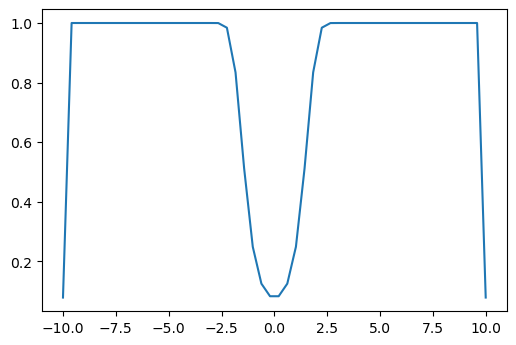

In [145]:
import numpy as np
import matplotlib.pyplot as plt 
import math as mt 
plt.rcParams['figure.dpi'] = 100

tau = 15.0
B_min = 1.0
B_max = 7.0
T_1 = 0.5
T_0 = 4.0*T_1
w_L = -0.34 
a_0 = 0.5
t = 1.0
delta = 30.0
x = np.linspace(-10,10)
y = []
for i in range(len(x)):
    y_temp = ((1+mt.erf( (x[i]**2)*(t-T_1) - B_min**2))/2)*((1-mt.erf( (x[i]**2)*(t-T_1) - B_max**2))/2)
    y.append(y_temp)
plt.plot(x, y)


def f1(B):
    f1_out = ((1+special.erf((B**2)*(t-T_1) - B_min**2))/2)*((1-special.erf((B**2)*(t-T_1) - B_max**2))/2)
    return f1_out


In [146]:
from pylab import array, linspace, subplots

tt = np.linspace(0, 1000, 3000)
def alpha():
     a = a_0*(1+ 0.02*random.uniform(-1,1))

     return a 

# a_s = [] 
# for i in range(len(tt)):
#     a_temp = alpha(tt[i])
#     a_s.append(a_temp)

a0 = np.linspace(0.24, 10000.0, 50)
yy_s = []

#a = 0.24 
for a in a0 :
    def model(Y, t, d):
        x, y = Y(t)
        xd0, yd0 = Y(t - d_0)
        xd1, yd1 = Y(t - d_1)
        return array([w_L*yd0 - x/tau , a*f1(xd1)*xd1 - y/tau])

    g = lambda t: array([(B_max + B_min)/2, (B_max + B_min)/2])
    d_0 = T_0 
    d_1 = T_1  
    yy = ddeint(model, g, tt, fargs=(d_1,))
    yy_s.append(yy)

print(len(yy_s))


c:\Users\abhin\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1013: UserWarning: vode: Repeated error test failures. (Check all input.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


50


Text(0, 0.5, '$\\alpha$')

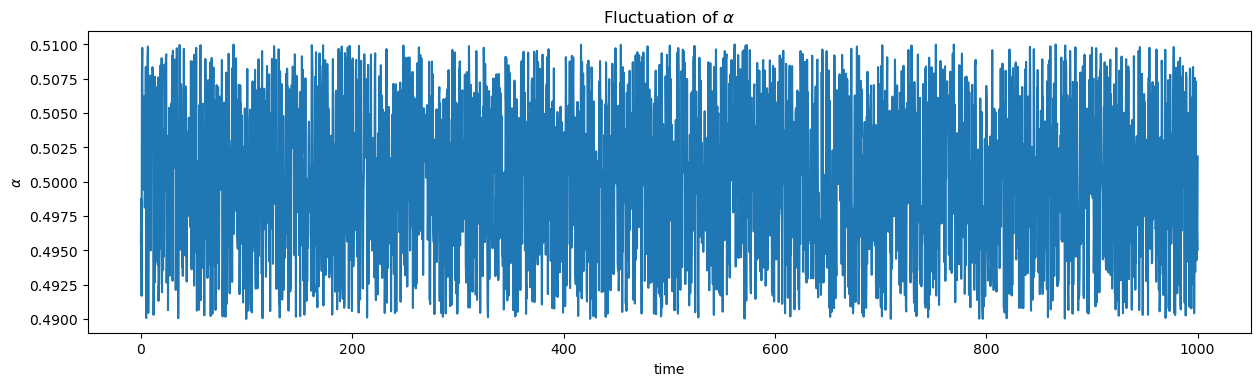

In [147]:
# max_vals = [] 
# for i in range(len(yy_s)) : 
#     m_t = max(yy_s[i][:,0]**2) 
#     max_vals.append(m_t)

# print(a0)

# plt.plot(a0, np.sqrt(max_vals))

a_fluc = [ ]
for i in range(len(tt)):
    a_fluc.append(alpha())

fig, ax = subplots(1, figsize=(15, 4))
plt.plot(tt, a_fluc)
plt.title(r"Fluctuation of $\alpha$ ")
plt.xlabel('time')
plt.ylabel(r'$\alpha$')

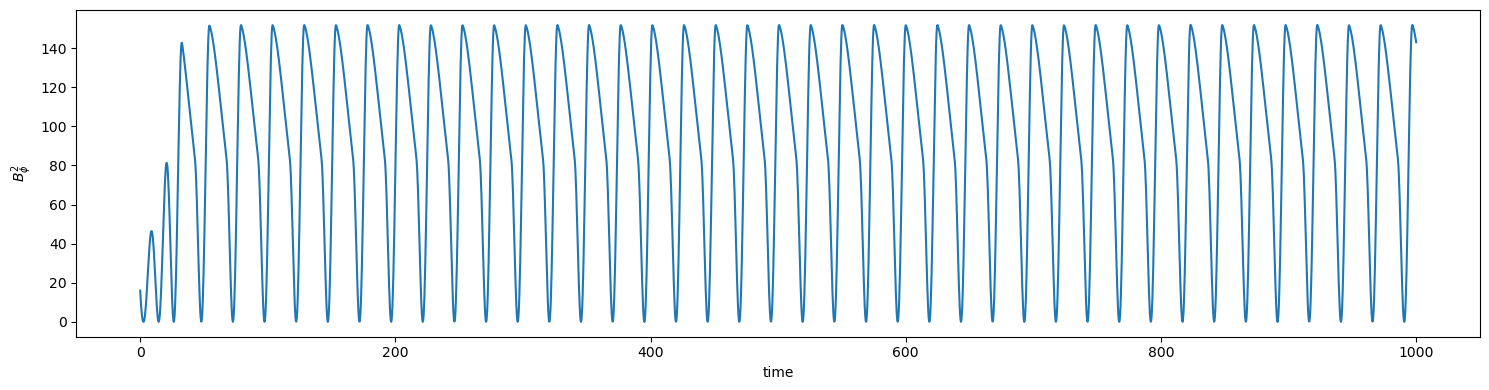

In [148]:
import statistics as stat

signal = yy_s[0][:, 0][2000:-1]**2
peak, _ = find_peaks(signal, height=0) 
#print("peaks at : ", peak)
#print("Energy values at peak : ", signal[peak])
avg_peak = np.average(signal[peak])


fig, ax = subplots(1, figsize=(15, 4))
ax.plot(tt, (yy_s[0][:, 0]**2))
#ax.plot(tt[400:-1], (yy_s[0][:, 0][400:-1])**2)
#ax.plot(tt, (yy_s[1][:, 0])**2)
#ax.plot(tt, (yy_s[2][:, 0])**2)
plt.xlabel('time')
plt.ylabel(r'$B^2_{\phi}$')
#plt.axhline(y = avg_peak, color = 'r')
#plt.title(r" Plot for $\alpha_0$ = {}".format(a0))
plt.tight_layout()
#plt.savefig('fixed_alpha.pdf')

# print(max(yy_s[0][:, 0]**2))

#print('variance = ', stat.variance(signal[peak]))



In [149]:
# from numpy.fft import fft, ifft

# ts = 500.0 
# sr = 1.0/ts
# X = fft(signal)
# N = len(X)
# n = np.arange(N)
# T = N*ts
# freq = n/T 

# plt.figure(figsize = (10, 6))


# plt.stem(freq, np.abs(X), 'b', \
#          markerfmt=" ", basefmt="-b")
# plt.xlabel('Freq (Hz)')
# plt.ylabel('FFT Amplitude |X(freq)|')

print((yy_s[0][:, 0][8990:-1])**2)

[]


Text(0, 0.5, '$B^{2}_{\\phi}$')

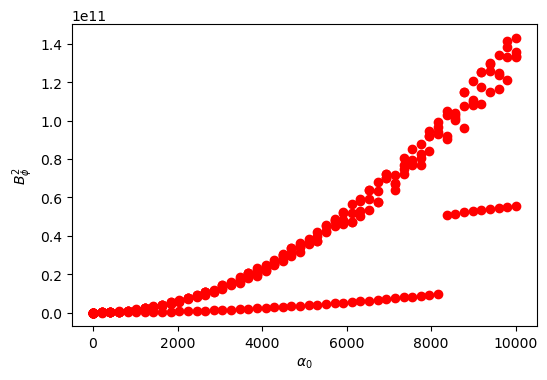

In [155]:
signals = []

for i in range(len(yy_s)):
    signal_t = yy_s[i][:, 0]**2
    peak_t, _ = find_peaks(signal_t, height=0) 
    signals.append(signal_t[peak_t])

for i in range(len(signals)):
    for j in range(len(signals[i])): 
        plt.plot(a0[i], signals[i][j], 'ro')

plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$B^{2}_{\phi}$')
#plt.yscale('log')